# Notebook Overview : Longitudinal motor clustering
This notebook allows the identification of motor evolution's subtrends with **kmeans longitudinal clustering** as motor recovery evaluation 

It loads the data from the *Data/Lisa* folder and save them after clustering in the *Data/Longitudinal* folder \
It also uses the longitudinal clustering and cluster comparison functions from *Longitudinal_Clustering.py*

It contains : 
- Silhouette scores for up to 8 clusters (this number can be changed)
- Visual comparison from 2 to 4 clusters and for each, a comparison was done with the acute multi-domain clustering
- 3 was the chosen number of clusters to be saved in the *Longitudinal* folder

This notebook can be run for two different data sets : one with all language tests combined and the other one with only the LAST_score


It has to be run after *Final_code_2.ipynb*  with the following parameters (to set in *Final_code_2.ipynb* and here in *Longitudinal_clustering_motor.ipynb*) : 

If we want all language tests combined except the LAST_score : 
- Set in *Final_code_2.ipynb*: \
"include_LAST_scores = False \
LAST_scores_no_language = False \
merge_memory_executive = True" 
- Set here in *Longitudinal_clustering_motor.ipynb* : \
LAST_scores_no_language = False


or if we only want the LAST_score for the language domain : 
- Set in *Final_code_2.ipynb*: \
"include_LAST_scores = False \
LAST_scores_no_language = True \
merge_memory_executive = True" 
- Set here in *Longitudinal_clustering_motor.ipynb* : \
LAST_scores_no_language = True

In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import Longitudinal_clustering as lc

# To make this notebook's output stable across runs
np.random.seed(255)

#To ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Important parameters to choose

In [2]:
# To choose the dataset
LAST_scores_no_language = False

#Nb of max clusters for the silhouette score
max_clusters = 8

domains = ["motor", "attention", "executive", "sensory", "language", "neglect"]
cluster_domain = "motor" # Domain on which we apply the clustering
n_domains = len(domains)
# colormap with unique colors for each label of Label_0 
colormap_label_0 = {"0": "blue", "1": "darkorange", "2": "red", "3": "green"}

# Import the 4 TiMeS datasets preprocessed and clustered by Aitana

In [3]:
root = r'../Data/Lisa/NMF_per_timepoint_merge_'
if LAST_scores_no_language:
    root = root + 'only_LAST_'

#Import the 4 TiMeS datasets, add time feature
NMF_1 = pd.read_csv(root+str(0)+'.csv').drop(columns=['Unnamed: 0']).assign(time="1").assign(time_in_weeks=1)
NMF_2 = pd.read_csv(root+str(1)+'.csv').drop(columns=['Unnamed: 0']).assign(time="2").assign(time_in_weeks=3)
NMF_3 = pd.read_csv(root+str(2)+'.csv').drop(columns=['Unnamed: 0']).assign(time="3").assign(time_in_weeks=12) #12 weeks = 3 months
NMF_4 = pd.read_csv(root+str(3)+'.csv').drop(columns=['Unnamed: 0']).assign(time="4").assign(time_in_weeks=52) #52 weeks = 1 year

#Merge the 4 TiMeS datasets in one
NMF = pd.concat([NMF_1, NMF_2, NMF_3, NMF_4])

#Change label column type for statistics purposes
NMF['Labels'] = NMF['Labels'].astype(str)

## Preprocessing

In [4]:
# Add feature of the first timepoint label to the NMF dataframe
NMF["Label_0"] = NMF.apply(lambda x: NMF_1[NMF_1["Patient"]==x["Patient"]]["Labels"].values[0].astype(str) if any(NMF_1["Patient"]==x["Patient"]) else np.nan, axis=1)

# Remove patients that have only one timepoint
NMF_new = NMF.groupby('Patient').filter(lambda x: len(x) > 1)
useless = NMF_new.groupby('Patient').filter(lambda x: len(x) <= 2)
display(useless)
print(useless.shape)


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0
4,0.014486,0.314425,0.337978,0.000000,0.279560,0.078781,P005,0,1,1,0
8,0.044361,0.473566,0.544241,0.216216,0.400802,0.208320,P009,1,1,1,1
20,0.054273,0.193072,0.321026,0.000000,0.296305,0.136203,P022,0,1,1,0
28,0.048080,0.374975,0.464582,0.021739,0.395952,0.078320,P032,1,1,1,1
31,0.616390,0.379135,0.386879,0.105466,0.302988,0.065383,P035,2,1,1,2
39,0.032881,0.461549,0.414228,0.000000,0.243593,0.066077,P043,1,1,1,1
43,0.021162,0.215157,0.233353,0.043478,0.230228,0.026893,P047,0,1,1,0
47,0.058081,0.261577,0.406461,0.021739,0.310574,0.163686,P053,0,1,1,0
49,0.703592,0.476206,0.566184,0.159634,0.369471,0.166058,P056,3,1,1,3
52,0.028441,0.260944,0.397031,0.000000,0.318082,0.044572,P059,0,1,1,0


(28, 11)


# Longitudinal Clustering with kmeans and Dynamic Time Warping

* As we have a dataset with a relatively small sample size, **kmeans** seemed to be a good clustering algorithm

* As the data time series have different length and do not start at the same time, euclidian distance cannot be computed for kmeans. \
By using **Dynamic Time Warping**, we develop a one to many match, and thus we can find an optimal alignment between two time series of different lengths \
With DBA (DTW barycenter averaging), multiple time series can be averaged https://www.sciencedirect.com/science/article/pii/S003132031000453X

Problem remaining : Preserve the exact temporal relationships in the data, should we interpolate ?


## Visualize Silhouette scores to choose the number of clusters

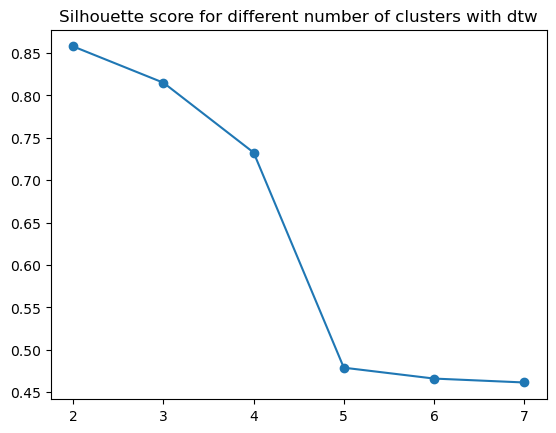

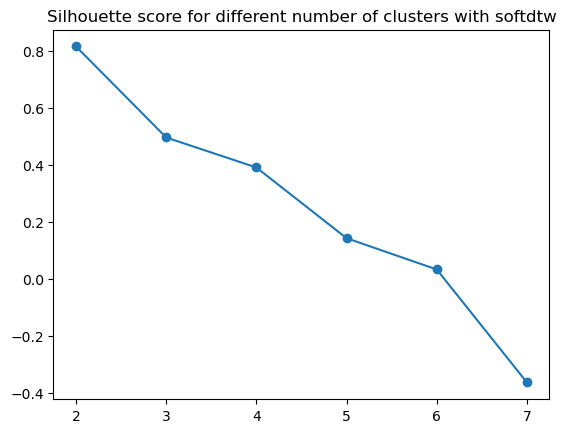

In [5]:
#get data in right format for clustering
data, df_data= lc.get_time_series(NMF_new, cluster_domain)

#Choosing the number of clusters with the dtw metric
metric="dtw"
lc.choose_n_clusters(data, max_clusters, metric)

#Choosing the right number of clusters with the softdtw metric
metric="softdtw"
lc.choose_n_clusters(data, max_clusters, metric)

According to the silhouette score, the optimal number of clusters is 0.

## Visual comparison from 2 to 4 clusters 

### With 2 clusters

In [6]:
#Clustering
n_clusters=2
metric="dtw"
labels, km = lc.kmeans_clustering(data, n_clusters, metric)

# Sorting the cluster labels based on the number of points they contain
ordered_labels_list = lc.order_clusters(data, labels)

#Add labels to the original dataframe
NMF_new = lc.add_labels_to_NMF(df_data, NMF_new, ordered_labels_list, domain=cluster_domain)
display(NMF_new)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0,longitudinal_motor_labels
0,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,P001,0,1,1,0,0
1,0.003425,0.170126,0.328080,0.000000,0.300511,0.047076,P001,0,2,3,0,0
2,0.003898,0.204180,0.213347,0.010526,0.243593,0.017072,P001,0,3,12,0,0
3,0.003055,0.177056,0.248852,0.000000,0.267846,0.014714,P001,0,4,52,0,0
4,0.036073,0.179785,0.332524,0.000000,0.210102,0.037255,P002,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.047187,0.481552,0.412853,0.000000,0.352398,0.132609,P079,1,2,3,NaN,0
217,0.033269,0.396613,0.435969,0.000000,0.210928,0.148478,P079,1,3,12,NaN,0
218,0.031642,0.429661,0.407130,0.000000,0.339859,0.088666,P079,1,4,52,NaN,0
219,0.085931,0.333692,0.386517,0.014127,0.236911,0.038064,P052,0,3,12,NaN,0


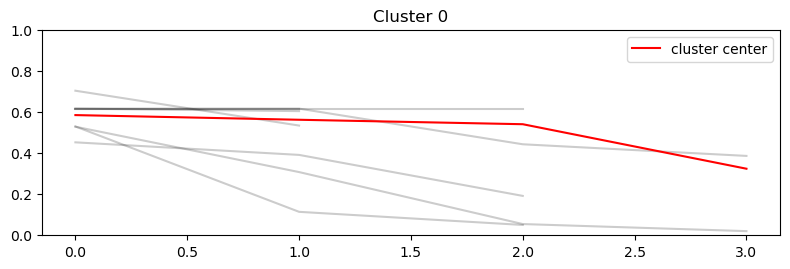

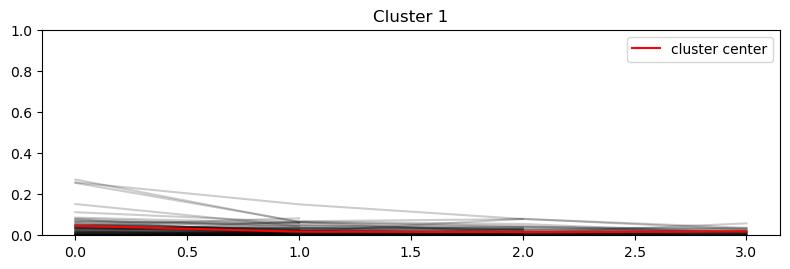

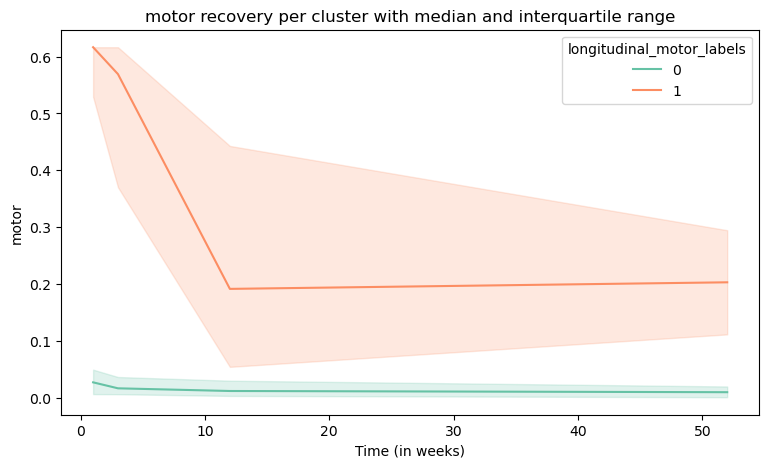

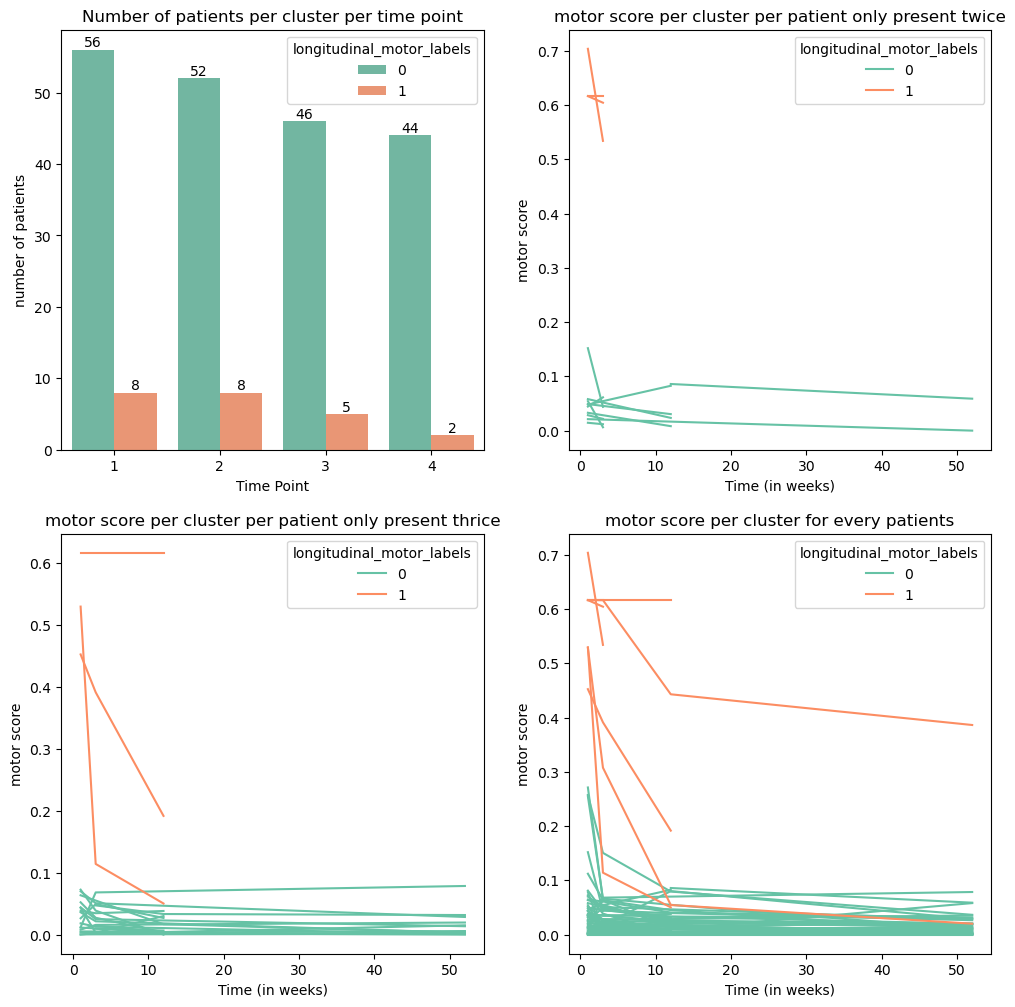

In [7]:
#Visualization
lc.plot_clusters(n_clusters, data, labels, km)
lc.clusters_info(NMF_new,cluster_domain)

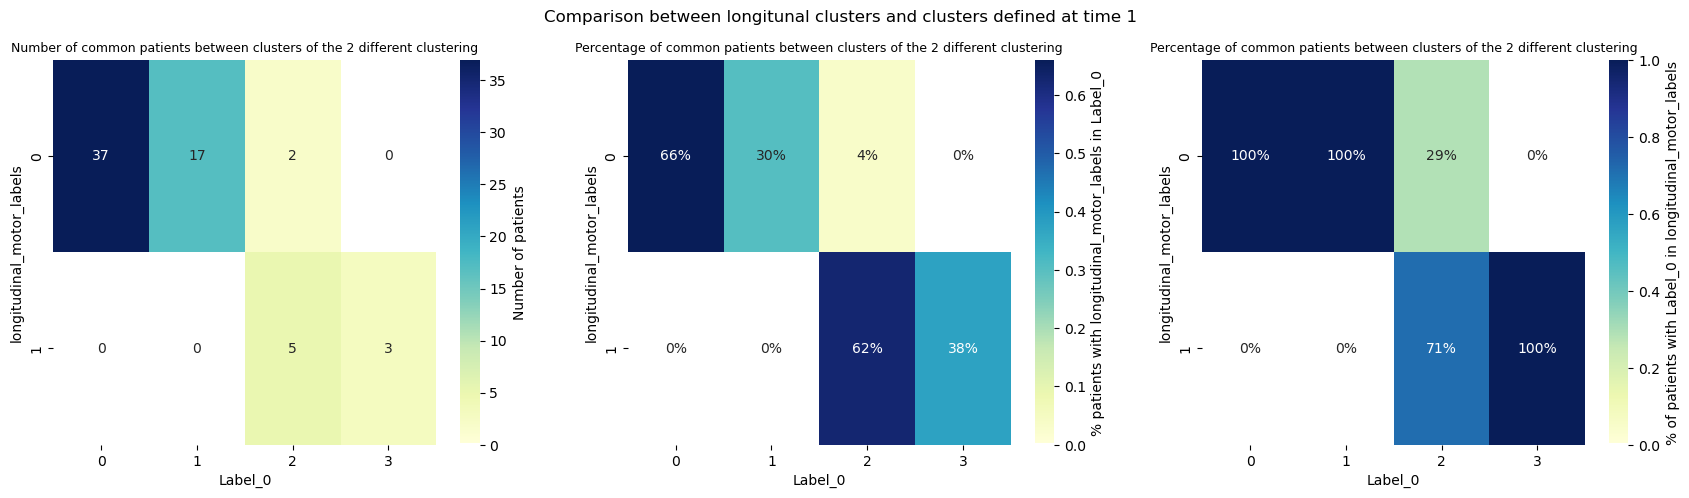

In [8]:
#Comparison between clusters at time 1 and longitudinal clusters (Acute Multi-Domain cluster vs longitudinal motor cluster)
lc.comparison2(NMF_new, "longitudinal_motor_labels", "Label_0", "Comparison between longitunal clusters and clusters defined at time 1")

By observing the comparison between longitudinal clusters and clusters defined at time 1 :

* 100% of cluster 0 from Label_0 belongs to longitudinal cluster 0 
* 100% of cluster 1 from Label_0 belongs to longitudinal cluster 0 

Thus the entirety of clusters 0 and 1 from Label_0 belongs to cluster 0 of longitudinal clustering

* 29% of cluster 2 from Label_0 belongs to longitudinal cluster 1 
* 71% of cluster 2 from Label_0 belongs to longitudinal cluster 2 
* 100% of cluster 3 from Label_0 belongs to longitudinal cluster 3

Thus the major part of clusters 2 and 3 from Label_0 belongs to cluster 1 of longitudinal clustering

-->  Not very useful for our main question

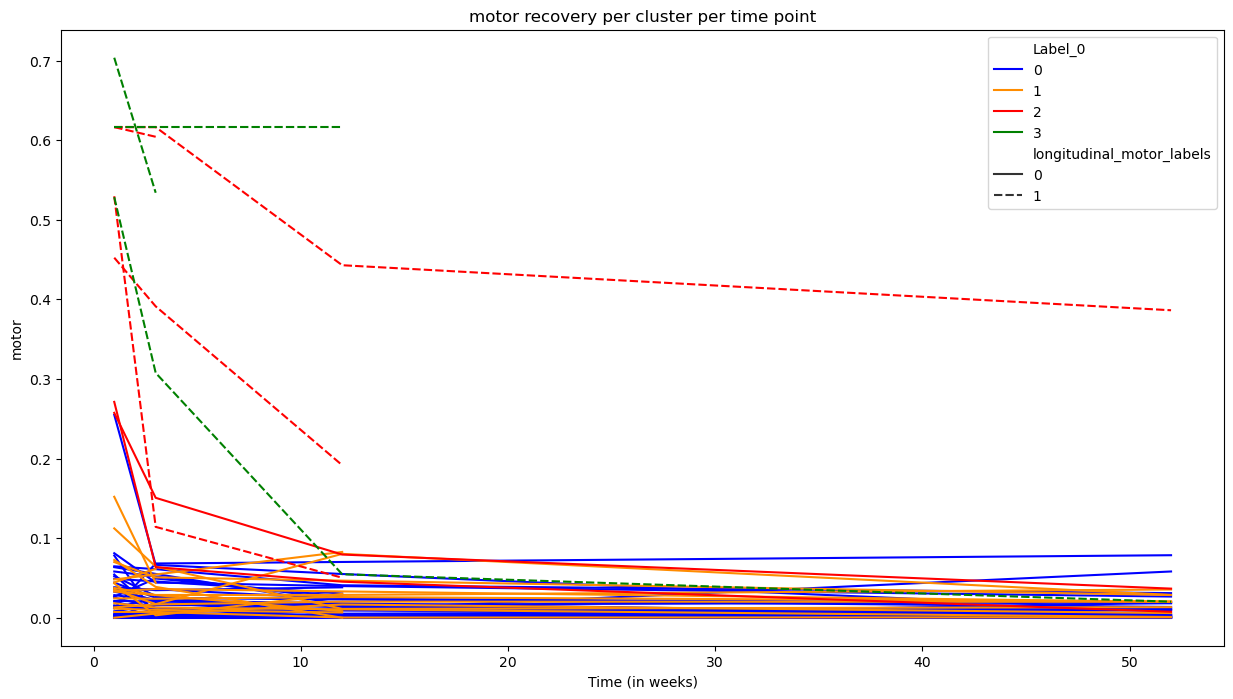

In [9]:
lc.lineplot_comparison(NMF_new, "Label_0", "longitudinal_motor_labels", colormap_label_0, cluster_domain)

By vizualizing the motor performance of the 2 labellings, we can observe that :
* The longitudinal clustering with 2 clusters seperate the set between patients who start with poor motor performance (longitudinal label 1) and patients who start with a good motor performance 
* The clustering previously done at time 1, as shown in Global_visualization, has 2 clusters with poor motor performance (cluster 2 and 3) an 2 clusters with good motor perfornace (clusters 0 and 1). Further distinctions between those clusters were based on cognitive performances.

### With 3 clusters

In [10]:
#Clustering
n_clusters=3
metric="dtw"
labels, km = lc.kmeans_clustering(data, n_clusters, metric)

# Sorting the cluster labels based on the number of points they contain
ordered_labels_list = lc.order_clusters(data, labels)

#Add labels to the original dataframe
NMF_new = lc.add_labels_to_NMF(df_data, NMF_new, ordered_labels_list, cluster_domain)
display(NMF_new)


[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 1 1 1 2 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 0 2 1 1 1 1 2 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 2 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 2 0 0 0 0 2 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0]


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0,longitudinal_motor_labels
0,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,P001,0,1,1,0,0
1,0.003425,0.170126,0.328080,0.000000,0.300511,0.047076,P001,0,2,3,0,0
2,0.003898,0.204180,0.213347,0.010526,0.243593,0.017072,P001,0,3,12,0,0
3,0.003055,0.177056,0.248852,0.000000,0.267846,0.014714,P001,0,4,52,0,0
4,0.036073,0.179785,0.332524,0.000000,0.210102,0.037255,P002,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.047187,0.481552,0.412853,0.000000,0.352398,0.132609,P079,1,2,3,NaN,0
217,0.033269,0.396613,0.435969,0.000000,0.210928,0.148478,P079,1,3,12,NaN,0
218,0.031642,0.429661,0.407130,0.000000,0.339859,0.088666,P079,1,4,52,NaN,0
219,0.085931,0.333692,0.386517,0.014127,0.236911,0.038064,P052,0,3,12,NaN,0


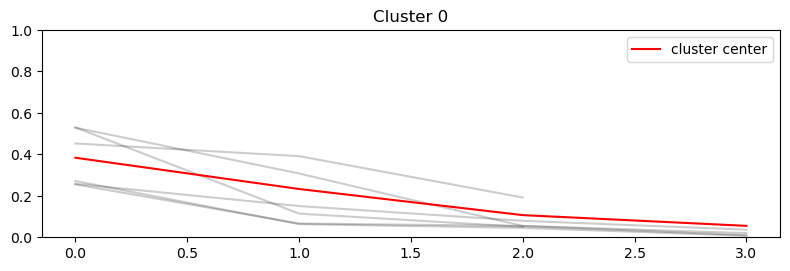

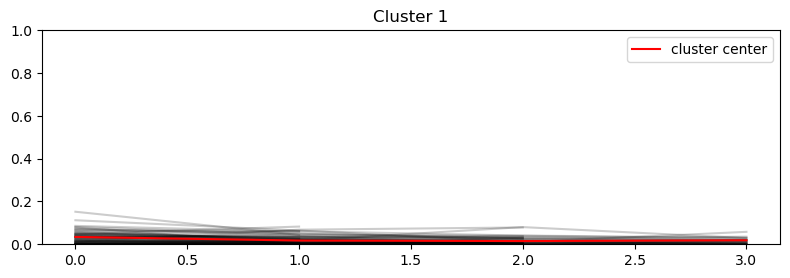

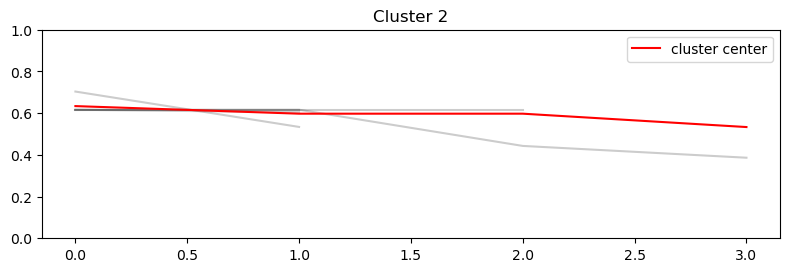

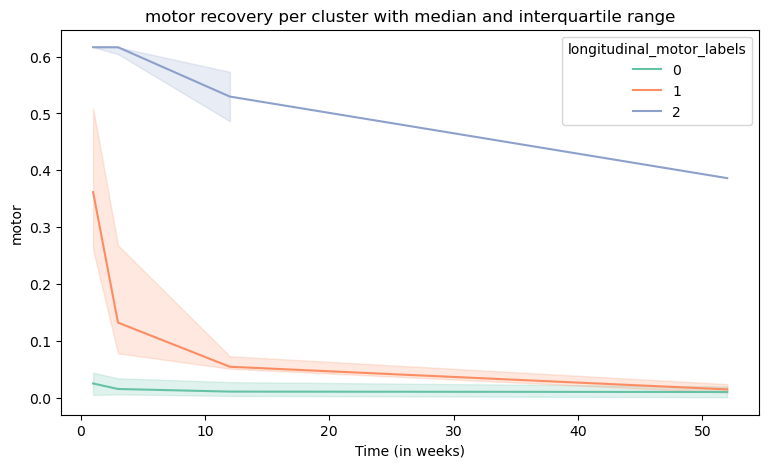

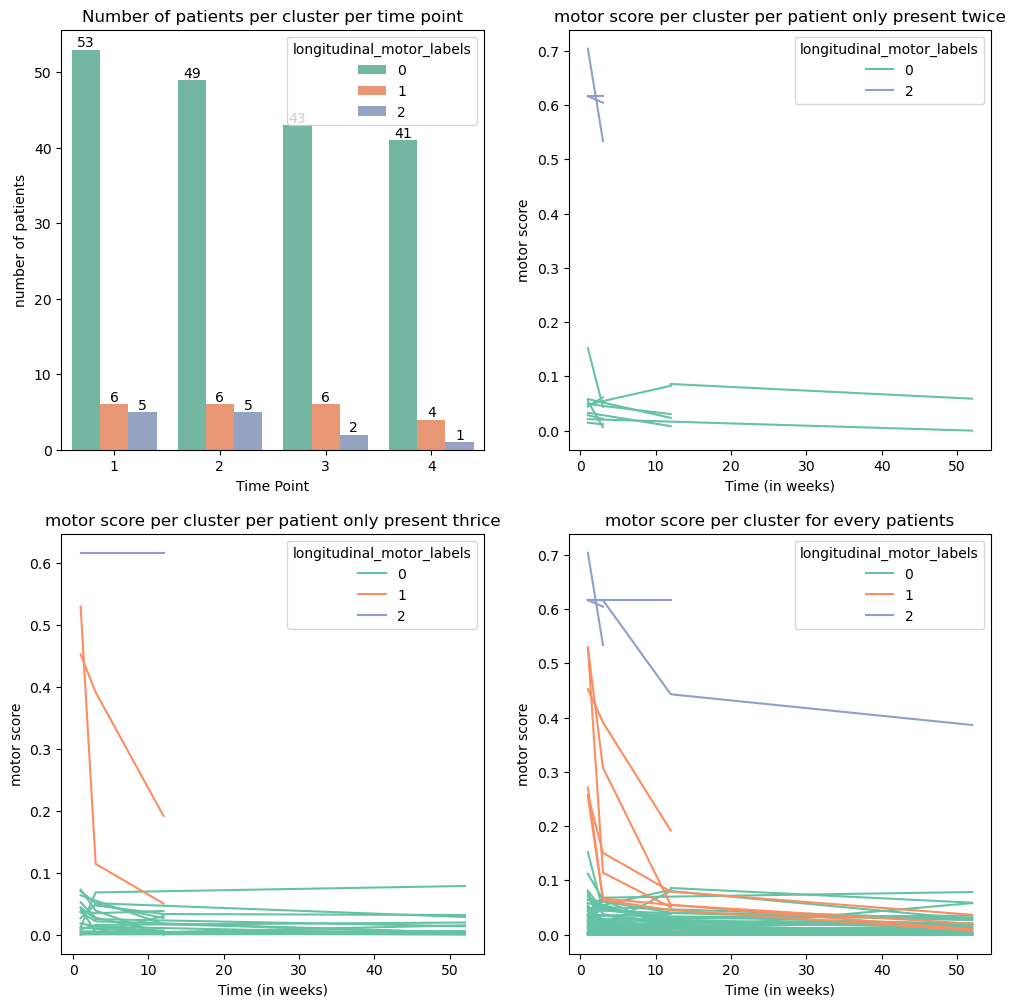

In [11]:
#Visualization
lc.plot_clusters(n_clusters, data, labels, km)
lc.clusters_info(NMF_new, cluster_domain)

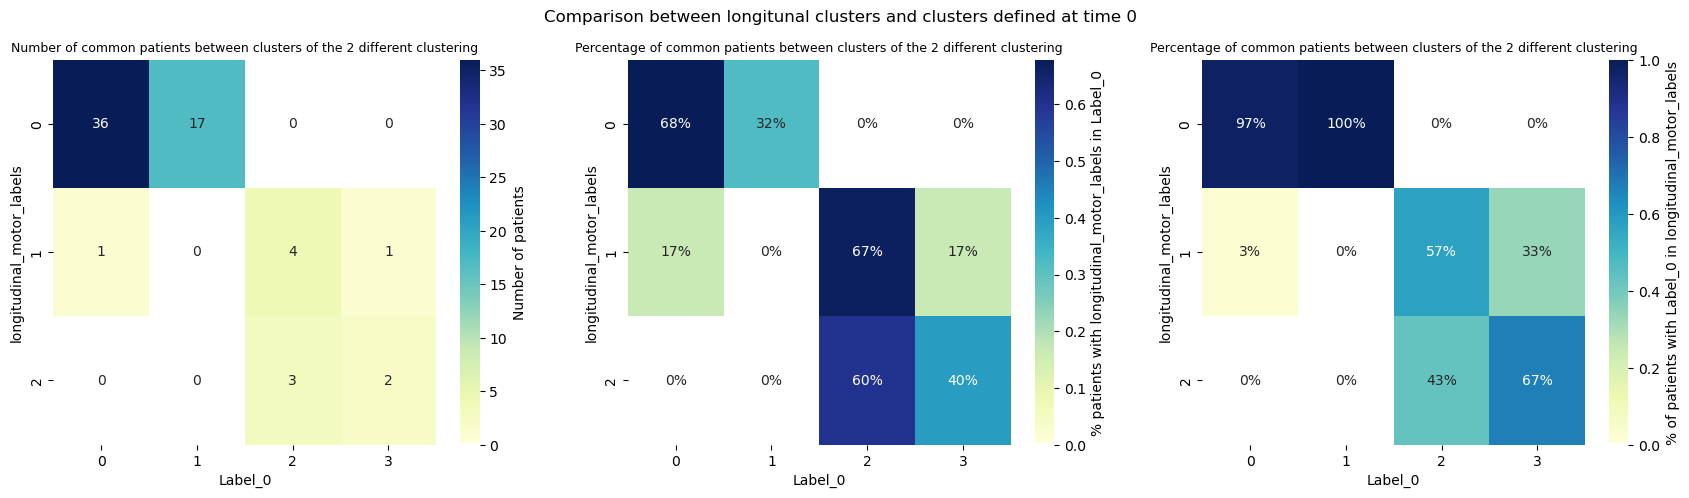

In [12]:
lc.comparison2(NMF_new, "longitudinal_motor_labels", "Label_0", "Comparison between longitunal clusters and clusters defined at time 0")

By observing the comparison between longitudinal clusters and clusters defined at time 0 :

* 97 % of cluster 0 from Label_0 belongs to longitudinal cluster 0 
* 100% of cluster 1 from Label_0 belongs to longitudinal cluster 0 

Thus almost the entirety of clusters 0 and 1 from Label_0 belongs to cluster 0 of longitudinal clustering

* 57% of cluster 2 from Label_0 belongs to longitudinal cluster 1 
* 43% of cluster 2 from Label_0 belongs to longitudinal cluster 2 
* 67% of cluster 3 from Label_0 belongs to longitudinal cluster 3

Thus the major part of clusters 2 and 3 from Label_0 are quite evenly distributed between cluster 1 and 2 of longitudinal clustering (But we do not really have enough data)

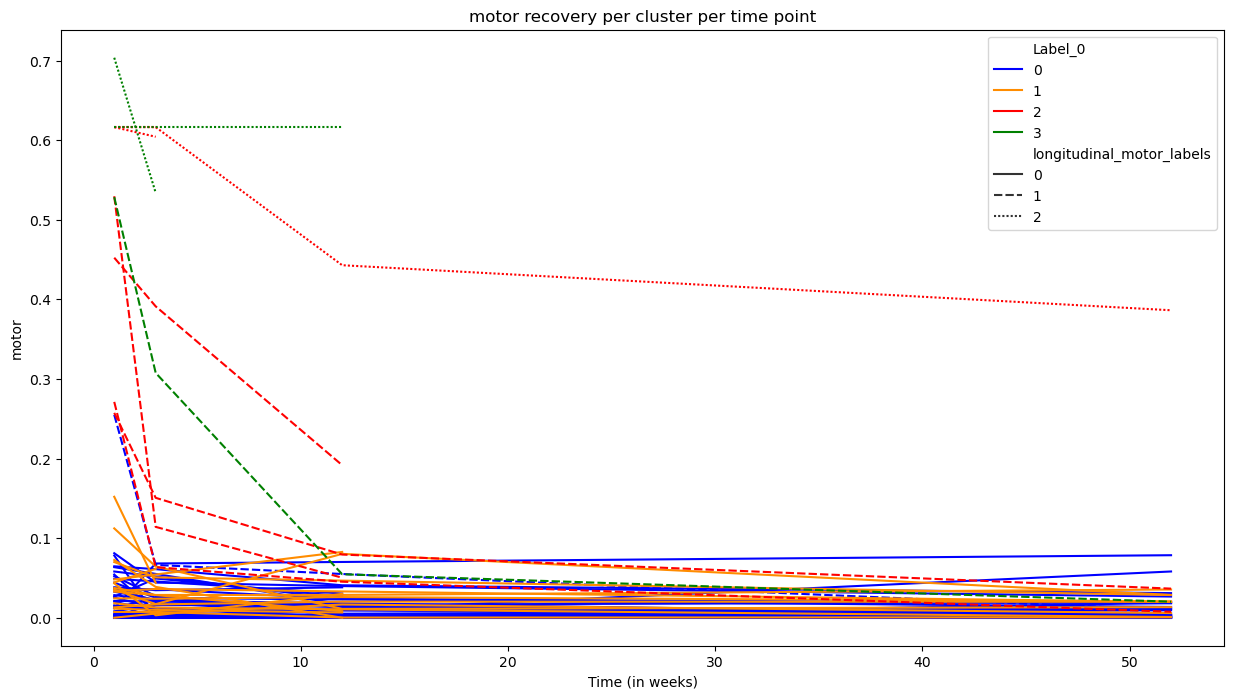

In [13]:
lc.lineplot_comparison(NMF_new, "Label_0", "longitudinal_motor_labels", colormap_label_0, cluster_domain)

/home/constance/Documents/epfl/CRR project/TiMeS_WP11_Constance/WP11_TiMeS/Code/Longitudinal_clustering.py:209: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(data=NMF, x="time_in_weeks", y=domain, hue=label0, style=label1, palette=palette, estimator =None, units="Patient")


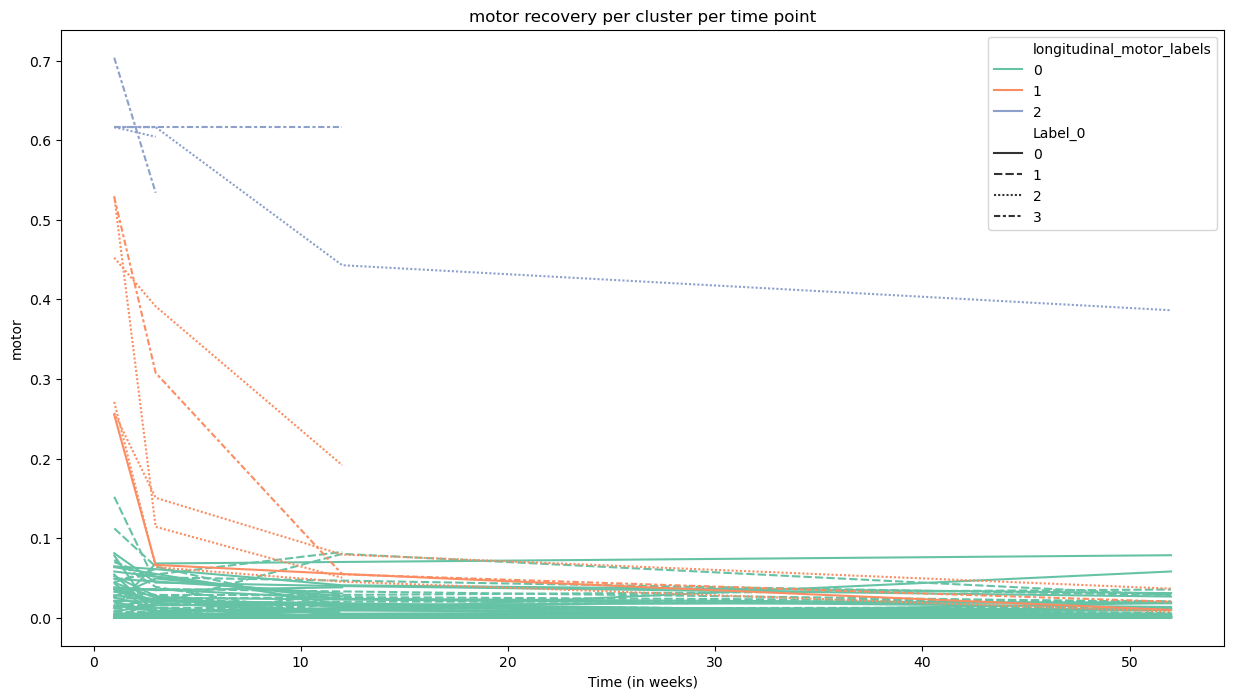

In [14]:
lc.lineplot_comparison(NMF_new, "longitudinal_motor_labels", "Label_0", sns.color_palette('Set2'), cluster_domain)

Longitudinal clustering make three distinctions :
* Very Bad motor performances which do not really improve (longitudinal_motor_labels cluster 2)
* Bad motor performances which have a strong improvement (longitudinal_motor_labels cluster 1)
* Good motor performances (longitudinal_motor_labels cluster 0)

Clusters at T=1, in particular :
* The ones that had poor motor, attention, executive, sensory and neglect domains (Label_0 cluster 3 - see Global_visualization) and \
the ones that had poor motor, mid attention, mid executive but good sensory and neglect domains (Label_0 cluster 2 - see Global_visualization) \
seem to be evenly distributed between the clusters 1 and 2 of longitudinal_moto_labels. \
Thus, clusters at time 1 based on the performance of every domains do not seem to be very predictive of the evolution of motor performances through time.

However we do not have enough data to be sure of this last point.


### Save the data with 3 clusters

In [15]:
# Where to save the dataframe
csv_path = "../Data/Longitudinal/"
file_name = "NMF_per_timepoint"
if LAST_scores_no_language:
    file_name = file_name + "only_LAST_"

# Remove Label_0 feature
NMF_to_save= NMF_new.drop(columns=["Label_0"])

#Save the dataframe
NMF_to_save.to_csv(csv_path + file_name + ".csv")

### With 4 clusters

In [16]:
#Clustering
n_clusters=4
metric="dtw"
labels, km = lc.kmeans_clustering(data, n_clusters, metric)

# Sorting the cluster labels based on the number of points they contain
ordered_labels_list = lc.order_clusters(data, labels)

#Add labels to the original dataframe
NMF_new = lc.add_labels_to_NMF(df_data, NMF_new, ordered_labels_list,cluster_domain)
display(NMF_new)

[1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2 1 1 1 1 1 3 1 1 1 1 1 2 1 1 3 1 1 1 1 1
 1 1 1 0 1 1 1 0 2 1 1 1 1 2 1 1 1 1 1 1 3 0 2 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 1 0 0 2 0 0 0 0 0
 0 0 0 3 0 0 0 3 1 0 0 0 0 1 0 0 0 0 0 0 2 3 1 0 0 0 0 0 0 0 0]


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0,longitudinal_motor_labels
0,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,P001,0,1,1,0,0
1,0.003425,0.170126,0.328080,0.000000,0.300511,0.047076,P001,0,2,3,0,0
2,0.003898,0.204180,0.213347,0.010526,0.243593,0.017072,P001,0,3,12,0,0
3,0.003055,0.177056,0.248852,0.000000,0.267846,0.014714,P001,0,4,52,0,0
4,0.036073,0.179785,0.332524,0.000000,0.210102,0.037255,P002,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.047187,0.481552,0.412853,0.000000,0.352398,0.132609,P079,1,2,3,NaN,0
217,0.033269,0.396613,0.435969,0.000000,0.210928,0.148478,P079,1,3,12,NaN,0
218,0.031642,0.429661,0.407130,0.000000,0.339859,0.088666,P079,1,4,52,NaN,0
219,0.085931,0.333692,0.386517,0.014127,0.236911,0.038064,P052,0,3,12,NaN,0


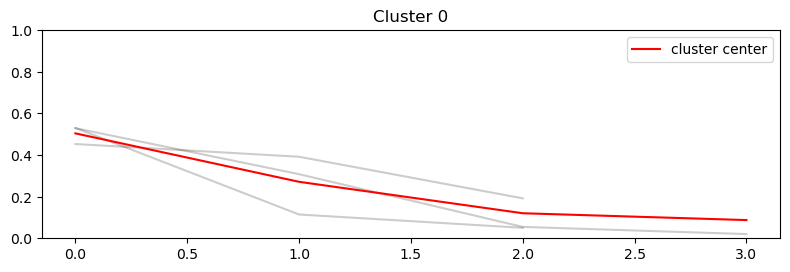

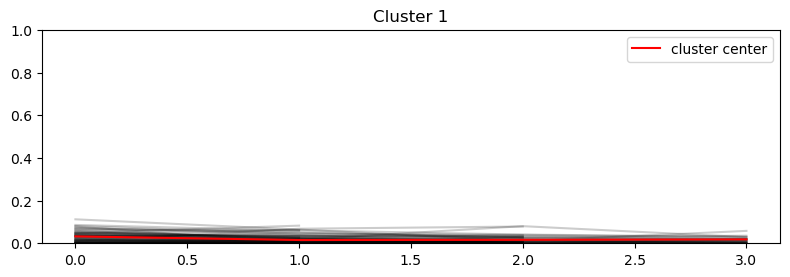

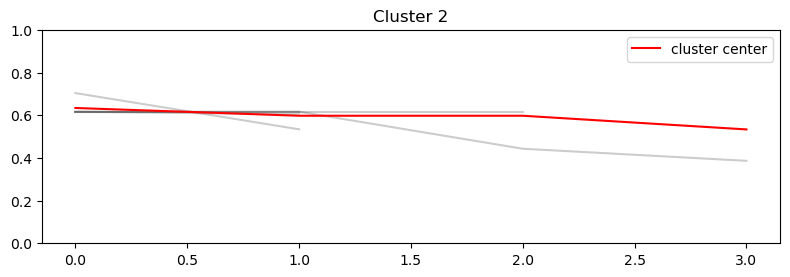

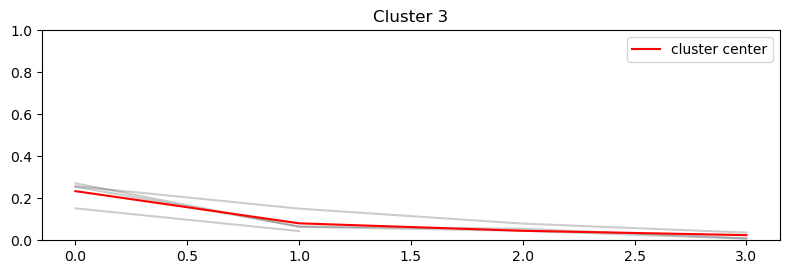

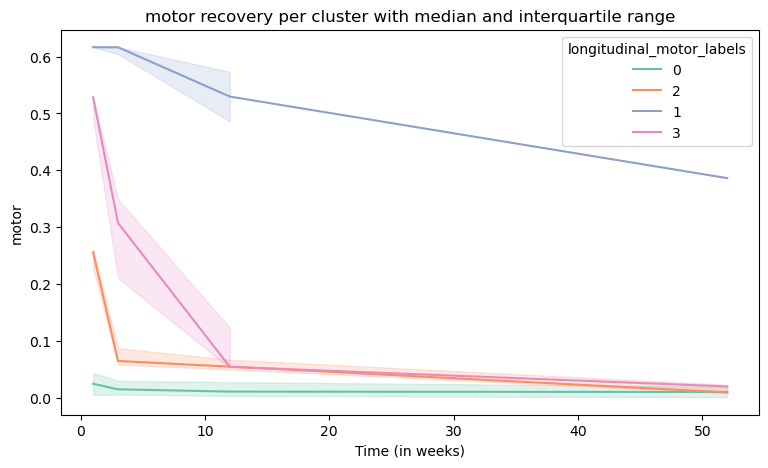

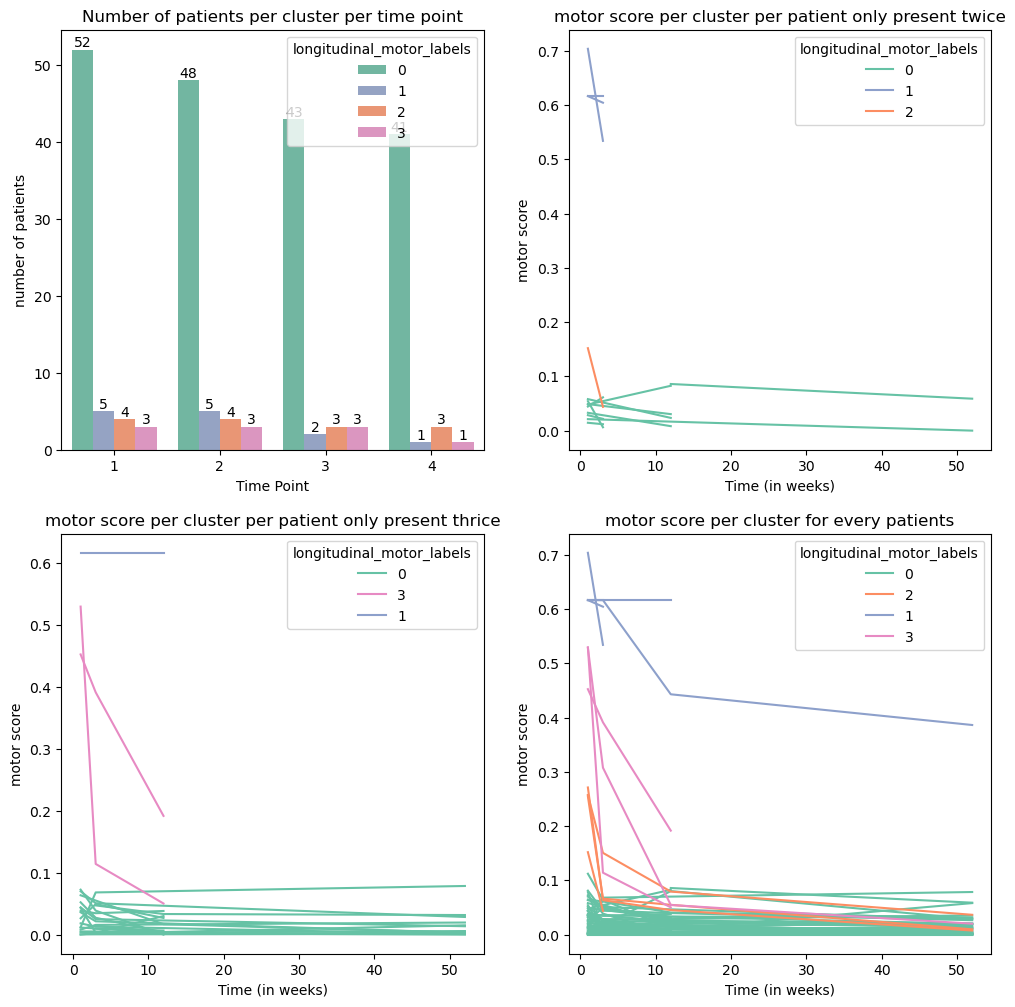

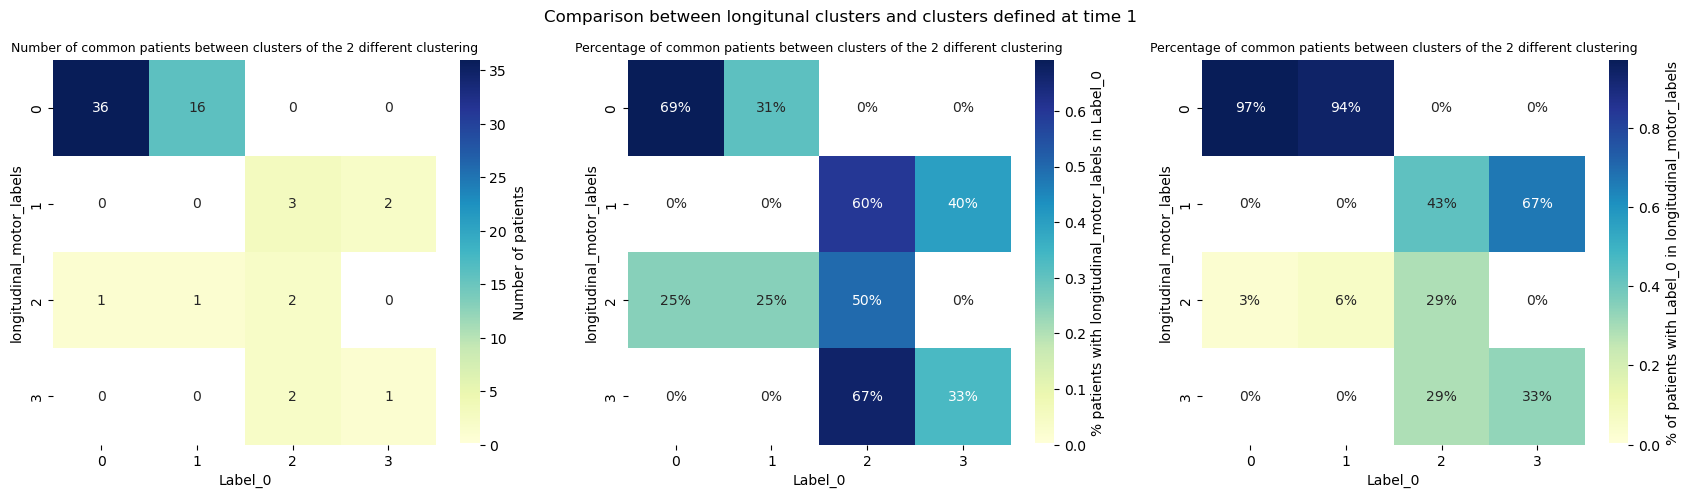

In [17]:
#Visualization
lc.plot_clusters(n_clusters, data, labels, km)
lc.clusters_info(NMF_new, cluster_domain)
lc.comparison2(NMF_new, "longitudinal_motor_labels", "Label_0", "Comparison between longitunal clusters and clusters defined at time 1")

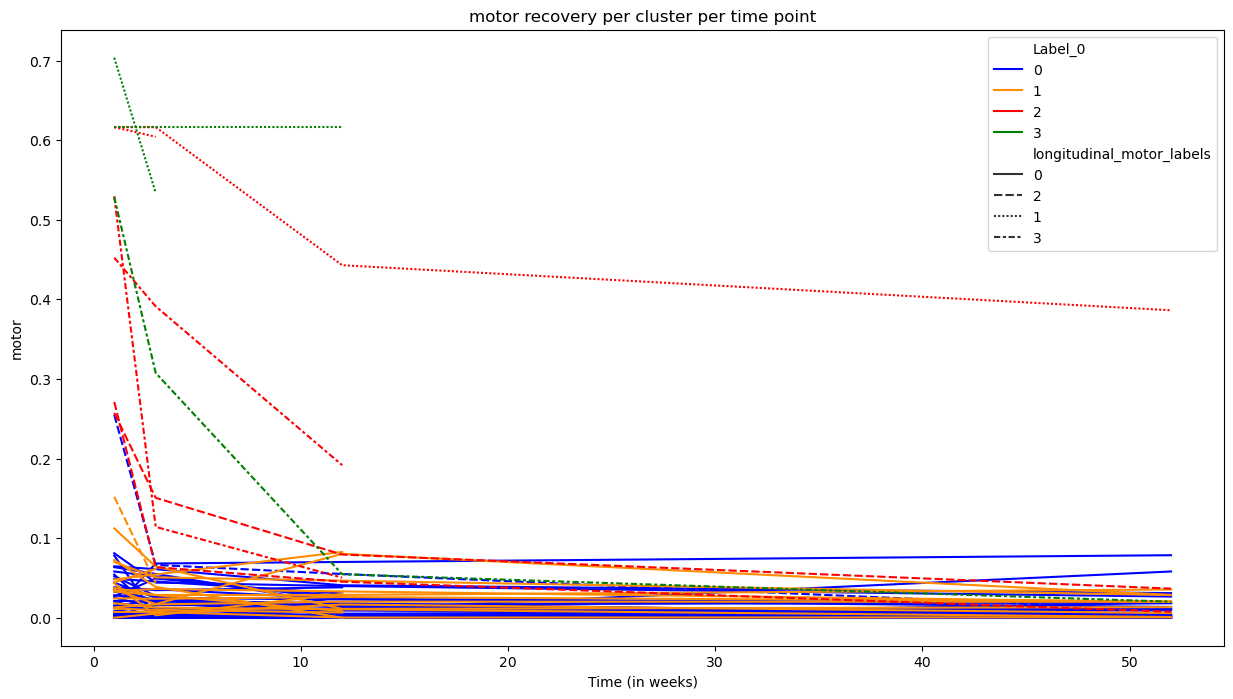

In [18]:
lc.lineplot_comparison(NMF_new, "Label_0", "longitudinal_motor_labels", colormap_label_0, cluster_domain)

Longitudinal clustering make four distinctions :
* Very Bad motor performances which do not really improve (longitudinal_motor_labels cluster 1)
* Bad motor performances which have a strong improvement (longitudinal_motor_labels cluster 3)
* Mid motor performances which have a strong improvement (longitudinal_motor_labels cluster 2)
* Good motor performances (longitudinal_motor_labels cluster 0)